In [1]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os, sys

import torch
import torch_geometric
import torch.nn.functional as F
import torch_geometric.transforms as pyg_T
from torch_geometric.utils import to_networkx, from_networkx

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

- https://github.com/mklimasz/TransE-PyTorch
- https://github.com/torchkge-team/torchkge/blob/master/torchkge/models/translation.py

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IMDB, OGB_MAG

dataset = IMDB(root=os.path.join("..", "data", "tmp", "IMDB"), transform=pyg_T.ToUndirected())
data = dataset.data
num_classes = torch.max(data["movie"].y).item() + 1  # IMDB doesn't have num_classes for some reason

# dataset = OGB_MAG(root =  os.path.join('..', 'data', 'tmp', "OGB_MAG"), preprocess='metapath2vec', transform=pyg_T.ToUndirected())

data = data.to_homogeneous()
data

Data(x=[11616, 3066], edge_index=[2, 34212], edge_type=[34212])

In [3]:
G = nx.DiGraph()
G.add_node("Arimidex", node_type="Drug")
G.add_node("Fulvestrant", node_type="Drug")
G.add_node("Breast Cancer", node_type="Disease")
G.add_node("Headache", node_type="Adverse Event")
G.add_node("Brain Bleeding", node_type="Adverse Event")
G.add_node("Kidney Infection", node_type="Adverse Event")
G.add_node("Short of breath", node_type="Adverse Event")
G.add_node("CASP8", node_type="Protein")
G.add_node("PIM1", node_type="Protein")
G.add_node("BIRC2", node_type="Protein")
G.add_node("ESR1", node_type="Protein")
G.add_node("ESR2", node_type="Protein")
G.add_node("BRCA1", node_type="Protein")


G.add_edge("Arimidex", "Breast Cancer", edge_type="Treat")
G.add_edge("Arimidex", "Headache", edge_type="Causes")
G.add_edge("Fulvestrant", "Headache", edge_type="Causes")
G.add_edge("Fulvestrant", "Breast Cancer", edge_type="Treat")
G.add_edge("Fulvestrant", "Brain Bleeding", edge_type="Causes")
G.add_edge("Fulvestrant", "Kidney Infection", edge_type="Causes")
G.add_edge("Fulvestrant", "Short of breath", edge_type="Causes")
G.add_edge("Fulvestrant", "ESR2", edge_type="Assoc")
G.add_edge("Brain Bleeding", "CASP8", edge_type="Assoc")
G.add_edge("Kidney Infection", "PIM1", edge_type="Assoc")
G.add_edge("Short of breath", "CASP8", edge_type="Assoc")
G.add_edge("Short of breath", "BIRC2", edge_type="Assoc")
G.add_edge("Breast Cancer", "BIRC2", edge_type="Assoc")
G.add_edge("Breast Cancer", "ESR1", edge_type="Assoc")
G.add_edge("Breast Cancer", "ESR2", edge_type="Assoc")
G.add_edge("Breast Cancer", "BRCA1", edge_type="Assoc")
G.add_edge("BRCA1", "ESR2", edge_type="Interact")
G.add_edge("ESR2", "BRCA1", edge_type="Interact")
G.add_edge("ESR2", "ESR1", edge_type="Interact")
G.add_edge("ESR1", "ESR2", edge_type="Interact")
G.add_edge("BRCA1", "ESR1", edge_type="Interact")
G.add_edge("ESR1", "BRCA1", edge_type="Interact")

In [4]:
node_color_dict = {"Disease": "red", "Drug": "lightblue", "Protein": "yellow", "Adverse Event": "lightgreen"}
edge_color_dict = {
    "Causes": "red",
    "Assoc": "green",
    "Treat": "orange",
    "Interact": "grey",
}

In [5]:
edge_labels = nx.get_edge_attributes(G, "edge_type")
node_colors = [node_color_dict[t] for t in nx.get_node_attributes(G, "node_type").values()]
edge_colors = [edge_color_dict[t] for t in nx.get_edge_attributes(G, "edge_type").values()]

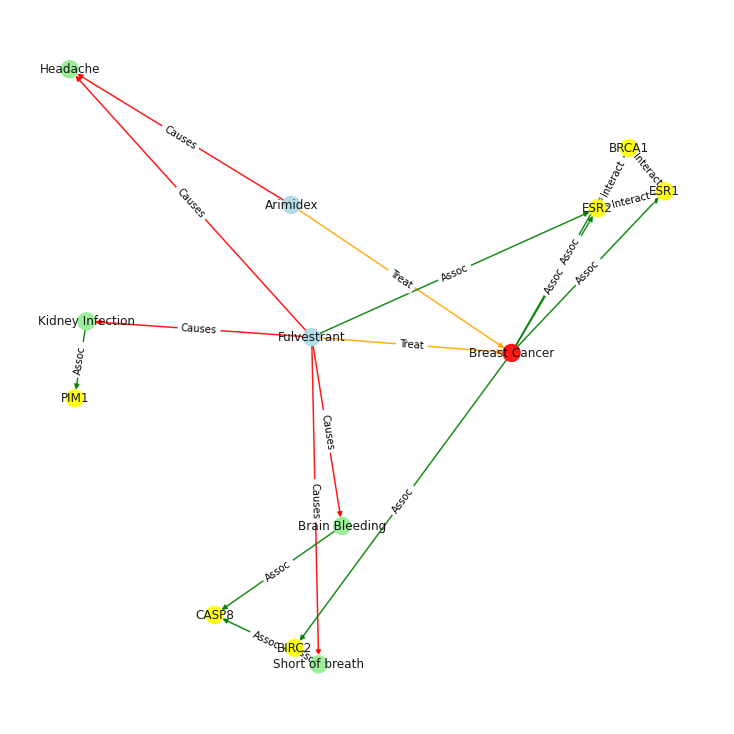

In [9]:
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G, seed=42, k=0.3, iterations=40)
nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, alpha=0.9, width=1.5)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

plt.show()

In [10]:
data = from_networkx(G)
data
data["node_type"] = torch.tensor(LabelEncoder().fit_transform(data["node_type"]))
data["edge_type"] = torch.tensor(LabelEncoder().fit_transform(data["edge_type"]))
data

Data(edge_index=[2, 22], node_type=[13], edge_type=[22], num_nodes=13)

In [11]:
G = nx.DiGraph()
G.add_node("Romania", node_type="Country")
G.add_node("USA", node_type="Country")
G.add_node("Author0", node_type="Author")
G.add_node("Author1", node_type="Author")
G.add_node("Author2", node_type="Author")
G.add_node("Author3", node_type="Author")
G.add_node("Author4", node_type="Author")
G.add_node("Author5", node_type="Author")
G.add_node("Author6", node_type="Author")
G.add_node("Author7", node_type="Author")
G.add_node("Author8", node_type="Author")
G.add_node("Author9", node_type="Author")

G.add_node("Paper0", node_type="Paper")
G.add_node("Paper1", node_type="Paper")
G.add_node("Paper2", node_type="Paper")
G.add_node("Paper3", node_type="Paper")
G.add_node("Paper4", node_type="Paper")


G.add_edge("Author0", "Romania", edge_type="is_from")
G.add_edge("Author1", "Romania", edge_type="is_from")
G.add_edge("Author2", "USA", edge_type="is_from")
G.add_edge("Author3", "USA", edge_type="is_from")
G.add_edge("Author4", "USA", edge_type="is_from")
G.add_edge("Author5", "USA", edge_type="is_from")
G.add_edge("Author6", "Romania", edge_type="is_from")
G.add_edge("Author7", "Romania", edge_type="is_from")
G.add_edge("Author9", "USA", edge_type="is_from")
G.add_edge("Author8", "USA", edge_type="is_from")


G.add_edge("Author0", "Paper0", edge_type="author_of")
G.add_edge("Author1", "Paper1", edge_type="author_of")
G.add_edge("Author2", "Paper0", edge_type="author_of")
G.add_edge("Author3", "Paper1", edge_type="author_of")
G.add_edge("Author4", "Paper1", edge_type="author_of")
G.add_edge("Author5", "Paper2", edge_type="author_of")

G.add_edge("Author6", "Paper3", edge_type="author_of")
G.add_edge("Author7", "Paper3", edge_type="author_of")
G.add_edge("Author8", "Paper3", edge_type="author_of")
G.add_edge("Author9", "Paper4", edge_type="author_of")

In [12]:
node_color_dict = {
    "Country": "red",
    "Author": "lightblue",
    "Paper": "yellow",
}
edge_color_dict = {
    "is_from": "red",
    "author_of": "green",
}

In [13]:
edge_labels = nx.get_edge_attributes(G, "edge_type")
node_colors = [node_color_dict[t] for t in nx.get_node_attributes(G, "node_type").values()]
edge_colors = [edge_color_dict[t] for t in nx.get_edge_attributes(G, "edge_type").values()]

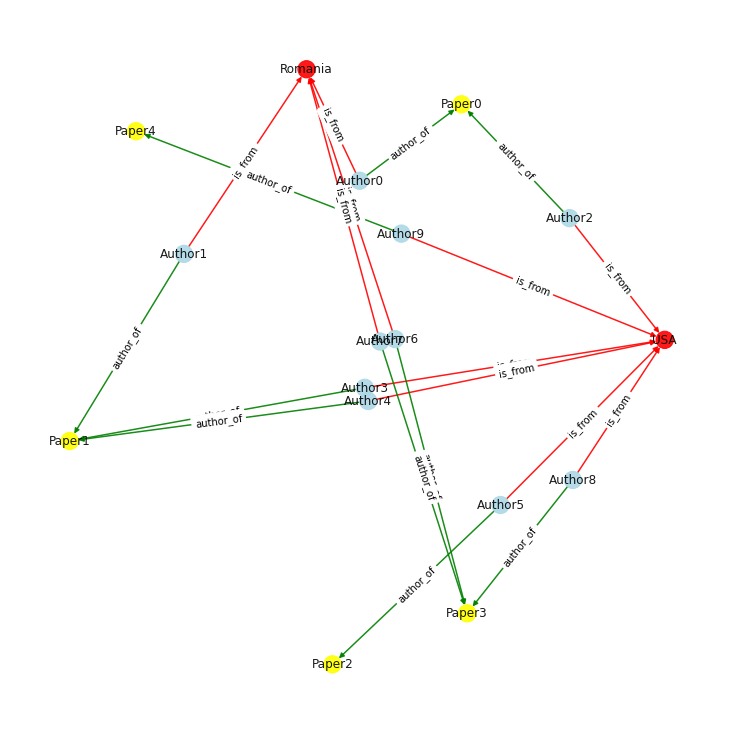

In [14]:
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G, seed=42, k=0.3, iterations=40)
nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, alpha=0.9, width=1.5)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

plt.show()

In [15]:
data = from_networkx(G)
data
data["node_type"] = torch.tensor(LabelEncoder().fit_transform(data["node_type"]))
data["edge_type"] = torch.tensor(LabelEncoder().fit_transform(data["edge_type"]))
data

Data(edge_index=[2, 20], node_type=[17], edge_type=[20], num_nodes=17)

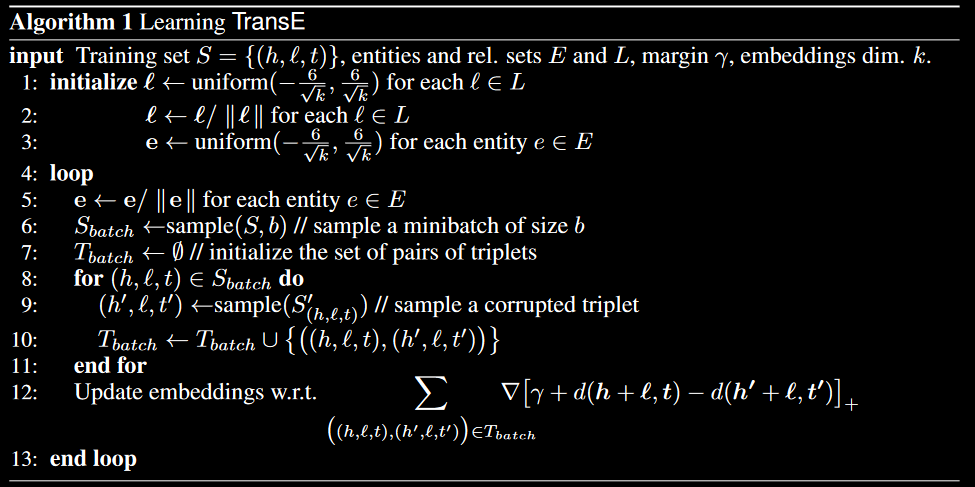

In [16]:
class TransE(torch.nn.Module):
    def __init__(self, num_entities, num_relations, dim=100, norm=2):
        super(TransE, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.dim = dim
        self.norm = norm

        # Lookup table of embeddings
        self.ent_embeddings = torch.nn.Embedding(self.num_entities, self.dim)
        self.rel_embeddings = torch.nn.Embedding(self.num_relations, self.dim)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Resets parameters. Normalizes the relations embeddings
        """
        self.ent_embeddings = torch.nn.Embedding(self.num_entities, self.dim)
        self.rel_embeddings = torch.nn.Embedding(self.num_relations, self.dim)

        uniform_range = 6 / np.sqrt(self.dim)
        self.ent_embeddings.weight.data.uniform_(-uniform_range, uniform_range)
        self.rel_embeddings.weight.data.uniform_(-uniform_range, uniform_range)
        self.rel_embeddings.weight.data = F.normalize(self.rel_embeddings.weight.data, p=self.norm, dim=-1)

    def forward(self, triplets):
        """
        Returns the model score. Triplets are of shape (3, B).
        `B` is the number of batches and `3` represents the head, relation and tail indexes
        """
        # Unpack. h_idx, r_idx, t_idx are of shape (B, )
        h_idx, r_idx, t_idx = triplets
        h = self.ent_embeddings(h_idx)
        r = self.ent_embeddings(r_idx)
        t = self.ent_embeddings(t_idx)

        # Normalize entities
        h = F.normalize(h, p=2, dim=-1)
        t = F.normalize(t, p=2, dim=-1)

        # Compute and return score
        return self.scoring_function(h, r, t)

    def scoring_function(self, h, r, t):
        return -(h + r - t).norm(p=self.norm, dim=-1)

    def get_embeddings(self):
        ent_embeddings = F.normalize(self.ent_embeddings.weight.data, p=self.norm, dim=-1)
        rel_embeddings = self.rel_embeddings.weight.data
        return ent_embeddings, rel_embeddings

In [17]:
def margin_loss(positive_scores, negative_scores, margin=0.5):
    return F.relu(margin + positive_scores - negative_scores).mean()

In [18]:
x_pos = torch.vstack([data.edge_index[0], data.edge_type, data.edge_index[1]])
x_pos

tensor([[ 2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10,
         11, 11],
        [ 1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
          1,  0],
        [ 0, 12,  0, 13,  1, 12,  1, 13,  1, 13,  1, 14,  0, 15,  0, 15,  1, 15,
          1, 16]])

In [19]:
torch.tensor([2, 1, 0]) in x_pos.T

True

In [20]:
def corrupt(x, num_nodes, all_triplets, head=True):
    all_nodes = np.arange(num_nodes)
    res = []
    for h, r, t in x.T:
        if head:
            sample_nodes = [new_node for new_node in all_nodes if torch.tensor([new_node, r, t]) not in all_triplets.T]
        else:
            sample_nodes = [new_node for new_node in all_nodes if torch.tensor([h, r, new_node]) not in all_triplets.T]

        new_node = np.random.choice(all_nodes)
        new_triplet = torch.tensor([new_node, r, t]) if head else torch.tensor([h, r, new_node])
        # If triplet not already there
        res.append(new_triplet)
    return torch.stack(res, dim=-1)

In [21]:
# corrupt head
t1 = x_pos[:, : x_pos.shape[1] // 2].clone()
t1 = corrupt(t1, data.num_nodes, x_pos)
# corrupt tail
t2 = x_pos[:, x_pos.shape[1] // 2 :].clone()
t2 = corrupt(t2, data.num_nodes, x_pos, head=False)

x_neg = torch.cat([t1, t2], dim=1)
x_neg

tensor([[ 3,  6,  8,  8, 11,  8,  7,  6, 14,  3,  7,  7,  8,  8,  9,  9, 10, 10,
         11, 11],
        [ 1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
          1,  0],
        [ 0, 12,  0, 13,  1, 12,  1, 13,  1, 13,  7,  6, 12,  1,  6, 12,  5, 11,
         11, 16]])

In [22]:
num_entities = data.num_nodes
num_relations = max(data.edge_type) + 1

In [46]:
transE = TransE(num_entities=num_entities, num_relations=num_relations, dim=5, norm=2)
loss_function = margin_loss
optimizer = torch.optim.SGD(transE.parameters(), lr=0.01)

transE.to(device)

TransE(
  (ent_embeddings): Embedding(17, 5)
  (rel_embeddings): Embedding(2, 5)
)

In [47]:
def train(model, x_pos, x_neg, optimizer, loss_fn):

    x_pos = x_pos.to(device)
    x_neg = x_neg.to(device)

    model.train()
    optimizer.zero_grad()

    positive_scores = transE(x_pos)
    negative_scores = transE(x_neg)
    loss = margin_loss(-positive_scores, -negative_scores, margin=1)
    loss.backward()
    optimizer.step()

    return loss.item()

In [56]:
epochs = 10000
for epoch in range(1, epochs + 1):
    loss_train = train(transE, x_pos, x_neg, optimizer, loss_function)
    if epoch % 500 == 0:
        print(f"{epoch = } | {loss_train=: .4f}")

epoch = 500 | loss_train= 0.1580
epoch = 1000 | loss_train= 0.1571
epoch = 1500 | loss_train= 0.1563
epoch = 2000 | loss_train= 0.1556
epoch = 2500 | loss_train= 0.1549
epoch = 3000 | loss_train= 0.1542
epoch = 3500 | loss_train= 0.1536
epoch = 4000 | loss_train= 0.1530
epoch = 4500 | loss_train= 0.1525
epoch = 5000 | loss_train= 0.1520
epoch = 5500 | loss_train= 0.1515
epoch = 6000 | loss_train= 0.1511
epoch = 6500 | loss_train= 0.1507
epoch = 7000 | loss_train= 0.1503
epoch = 7500 | loss_train= 0.1499
epoch = 8000 | loss_train= 0.1496
epoch = 8500 | loss_train= 0.1493
epoch = 9000 | loss_train= 0.1490
epoch = 9500 | loss_train= 0.1487
epoch = 10000 | loss_train= 0.1484


In [57]:
ent_emb, rel_emb = transE.get_embeddings()
h_idx, r_idx, t_idx = x_pos[:, [0, 1, 2, 3]]
h, r, t = ent_emb[h_idx], rel_emb[r_idx], ent_emb[t_idx]

transE.scoring_function(h, r, t)

tensor([-1.2886, -0.8519, -1.3868, -1.9681], device='cuda:0')

In [59]:
ent_emb, rel_emb = transE.get_embeddings()
h_idx, r_idx, t_idx = x_neg[:, [0, 1, 2, 3]]
h, r, t = ent_emb[h_idx], rel_emb[r_idx], ent_emb[t_idx]

transE.scoring_function(h, r, t)

tensor([-1.3868, -1.0506, -1.2040, -1.6134], device='cuda:0')

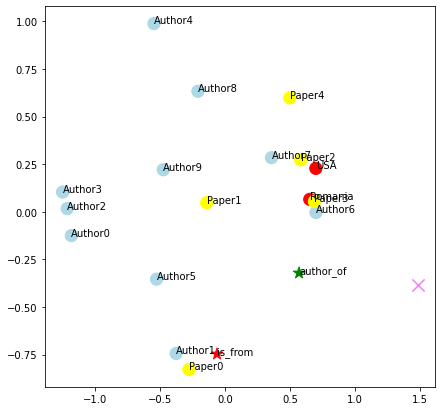

In [60]:
emb = ent_emb.cpu().numpy()
embr = rel_emb.cpu().numpy()
emb_all = np.concatenate([emb, embr], axis=0)


emb_all = np.concatenate([emb_all, [emb[0] + embr[1]]])
# emb_all = UMAP(n_components=2, n_neighbors=5).fit_transform(emb_all).T
emb_all = PCA(n_components=2).fit_transform(emb_all).T
# emb, embr = emb_all[:, :-num_relations], emb_all[:, -num_relations:]
emb, embr = emb_all[:, : -num_relations - 1], emb_all[:, -num_relations - 1 : -1]
emb0 = emb_all[:, -1]

plt.figure(figsize=(7, 7))
# Try to pca the embeddings
plt.scatter(*emb, c=node_colors, s=150)
plt.scatter(*embr, c=edge_color_dict.values(), s=150, marker="*")
plt.scatter(*emb0, c="violet", s=150, marker="x")

for i, txt in enumerate(G.nodes):
    plt.annotate(txt, (emb[0][i], emb[1][i]))
for i, txt in enumerate(edge_color_dict.keys()):
    plt.annotate(txt, (embr[0][i], embr[1][i]))

plt.show()

In [38]:
edge_color_dict.keys()

dict_keys(['is_from', 'author_of'])

In [39]:
G.nodes

NodeView(('Romania', 'USA', 'Author0', 'Author1', 'Author2', 'Author3', 'Author4', 'Author5', 'Author6', 'Author7', 'Author8', 'Author9', 'Paper0', 'Paper1', 'Paper2', 'Paper3', 'Paper4'))